# Example 1: Computing sensitivies for a piston

In [1]:
from equadratures import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#%matplotlib notebook

## 1. Setting up our problem

First set the parameters. Lets stick with ``distribution='uniform'`` and ``order=3``. The ranges are given in the slides.

In [2]:
order_parameters = 3
mass = Parameter(distribution='uniform', lower=30.0, upper=60.0, order=order_parameters)
area = Parameter(distribution='uniform', lower=0.005, upper=0.020, order=order_parameters)
volume = Parameter(distribution='uniform', lower=0.002, upper=0.010, order=order_parameters)
spring = Parameter(distribution='uniform', lower=1000., upper=5000., order=order_parameters)
pressure = Parameter(distribution='uniform', lower=90000., upper=110000., order=order_parameters)
ambtemp = Parameter(distribution='uniform', lower=290., upper=296., order=order_parameters)
gastemp = Parameter(distribution='uniform', lower=340., upper=360., order=order_parameters)

# Put the 7 parameters into a list
parameters = [mass, area, volume, spring, pressure, ambtemp, gastemp]
param_names = ['mass', 'area', 'volume', 'spring', 'pressure', 'ambtemp', 'gastemp']

We need to define a function to return the piston's cycle time, $C$, given the 7 input parameters. Equations are given in the slides.

In [3]:
def piston(x):
    mass, area, volume, spring, pressure, ambtemp, gastemp = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    A = pressure * area + 19.62*mass - (spring * volume)/(1.0 * area)
    V = (area/(2*spring)) * ( np.sqrt(A**2 + 4*spring * pressure * volume * ambtemp/gastemp) - A)
    C = 2 * np.pi * np.sqrt(mass/(spring + area**2 * pressure * volume * ambtemp/(gastemp * V**2)))
    return C

For $\mathbf{x}=1$ we expect $C=piston(x)\approx0.319$. Is your function correct?

In [19]:
piston([1,1,1,1,1,1,1])

0.31900432511842686

## 2. Fitting a polynomial

Firstly, lets set-up our ``Basis`` and ``Poly``. We will opt for a total order basis set with least-squares and qr subsampling.

In [4]:
mybasis = Basis('total-order')
mypoly  = Poly(parameters, mybasis, method='least-squares',sampling_args={'mesh':'tensor-grid', 'subsampling-algorithm':'qr', 'sampling-ratio':1.0})

Now (and this is the important part), we wish to ascertain how many model evaluations will be required for computing these sensitivities. The objective is for these to be orders of magnitude lower than other methods for computing Sobol’ indices.

In [5]:
print(mypoly.basis.cardinality)

120


Excellent! So the number of model evaluations we will require is 120! Now lets compute the coefficients and get the Sobol indices to ascertain which of the variables above are the most important.

As usual, lets now run ``set_model``. This time provide the function ``piston`` to ``set_model`` directly. The code can decide where to sample this function itself.

In [6]:
mypoly.set_model(piston)
mean, var = mypoly.get_mean_and_variance()

Using ``method='least-squares'`` and ``'subsampling-algorithm':'qr'`` has given us big savings here! If we had used ``method='numerical-integration'`` like in the CFD examples, we would have needed $4^7 = 16384$ samples. Later on you can check this for yourself! (See below, this may take a while to run).

In [7]:
#mybasis = Basis('tensor-grid')
#mypoly  = Poly(parameters, mybasis, method='numerical-integration')
#print(mypoly.basis.cardinality)

## 3. Obtaining Sobol' indices

Lets find the *unnormalised* Sobol' indices and compare to the reference solution. The ``get_sobol_indices()`` function returns the *normalised* Sobol' indices $S_i$ so we must multiply these by the variance of $C$ to get the *unnormalised* indices:

$\tau_i^2=S_i\sigma^2$

In [8]:
sobol = mypoly.get_sobol_indices(1)

# Print indices
for i in range(0, len(parameters)):
    print('%8s: %.2g' %(param_names[i],float(sobol[(i,)]) * 10**2 * var))

    mass: 0.079
    area: 1.1
  volume: 0.58
  spring: 0.041
pressure: 0.0027
 ambtemp: 0.00013
 gastemp: 0.00077


Are the values close to the reference values given in the slides? 

If they are, then lets go ahead and plot $S_i$ to understand the relative important of each input parameter.

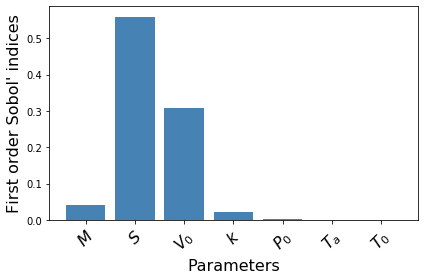

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
data_1 = np.arange(7) - 0.10 + 1
for i in range(0, len(sobol)):
    plt.bar(i+1, sobol[(i,)], color='steelblue',linewidth=1.5)
ax.set_axisbelow(True)
plt.xlabel(r'Parameters', fontsize=16)
plt.ylabel(r"First order Sobol' indices", fontsize=16)
xTickMarks = [r'$M$', r'$S$', r'$V_0$', r'$k$', r'$P_0$', r'$T_a$', r'$T_0$']
ax.set_xticks(data_1+0.10)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=16)
plt.tight_layout()
#plt.plot()

## 4. Higher order and total Sobol' indices

``get_sobol_indices()`` can also return higher order *interaction* indices. Try this my obtaining the 2nd and 3rd order indices below:

In [15]:
sobol2 = mypoly.get_sobol_indices(2)
sobol3 = mypoly.get_sobol_indices(3)

In [16]:
# Print indices
for key, value in sobol2.items():
    print('Parameters: %9s <> %9s, Sobol index: %.1g' %(param_names[key[0]],param_names[key[1]],value))

Parameters:      mass <>      area, Sobol index: 0.006
Parameters:      mass <>    volume, Sobol index: 0.006
Parameters:      mass <>    spring, Sobol index: 0.001
Parameters:      mass <>  pressure, Sobol index: 0.0008
Parameters:      mass <>   ambtemp, Sobol index: 3e-05
Parameters:      mass <>   gastemp, Sobol index: 5e-05
Parameters:      area <>    volume, Sobol index: 0.004
Parameters:      area <>    spring, Sobol index: 0.02
Parameters:      area <>  pressure, Sobol index: 0.0003
Parameters:      area <>   ambtemp, Sobol index: 0.0003
Parameters:      area <>   gastemp, Sobol index: 0.001
Parameters:    volume <>    spring, Sobol index: 0.01
Parameters:    volume <>  pressure, Sobol index: 0.0001
Parameters:    volume <>   ambtemp, Sobol index: 0.0001
Parameters:    volume <>   gastemp, Sobol index: 0.0002
Parameters:    spring <>  pressure, Sobol index: 0.0001
Parameters:    spring <>   ambtemp, Sobol index: 0.0004
Parameters:    spring <>   gastemp, Sobol index: 0.0004
Par

In a similar manner, ``get_total_sobol_indices()`` returns the total Sobel' indices $S_{T_i}$ (Total-effect indices). Try this...

In [12]:
sobol_tot = mypoly.get_total_sobol_indices()

# Print indices
print("\nTotal Sobol' indices")
for i in range(0, len(parameters)):
    print('%8s: %.2g' %(param_names[i],float(sobol_tot[(i,)])))
print("\nSobol' indices")
for i in range(0, len(parameters)):
    print('%8s: %.2g' %(param_names[i],float(sobol[(i,)])))


Total Sobol' indices
    mass: 0.059
    area: 0.6
  volume: 0.34
  spring: 0.066
pressure: 0.0055
 ambtemp: 0.0036
 gastemp: 0.0047

Sobol' indices
    mass: 0.041
    area: 0.56
  volume: 0.31
  spring: 0.022
pressure: 0.0014
 ambtemp: 6.7e-05
 gastemp: 0.00041


Total Sobol' indices measure each parameter's contribution to the output variance, including all variance caused by it's interactions (of any order) with any other input variables.

We expect $\sum_{i=1}^d S_{T_i} \ge 1$. Check this using ``sum()`` or ``np.sum()``.

In [18]:
sum(sobol_tot)

1.0790724655598465

Note that $\sum_{i=1}^d S_{T_i} = 1$ only if the model/system is purely additive.